## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Retrieve dataset 
For the project the training dataset ([vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images) provided  was used. The extraction of the data is done below.

In [1]:
import glob
import matplotlib.image as mpimg

car_files = glob.glob('dataset/vehicles/**/*.png')
noncar_files = glob.glob('dataset/non-vehicles/**/*.png')

print('The dataset consists of {} car and {} non-car images'.format(len(car_files), len(noncar_files)))

The dataset consists of 8792 car and 8968 non-car images


In [2]:
import numpy as np
import cv2
%matplotlib inline
car_imgs = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in car_files]
noncar_imgs = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in noncar_files]
example_img = car_imgs[np.random.randint(0, len(car_imgs))]
print('The shape of the images is: {}'.format(example_img.shape))
print("The min value is {} and the max value of the image is {}".format(np.amin(example_img),
                                                                     np.amax(example_img)))

The shape of the images is: (64, 64, 3)
The min value is 5 and the max value of the image is 201


## Visualize sample data

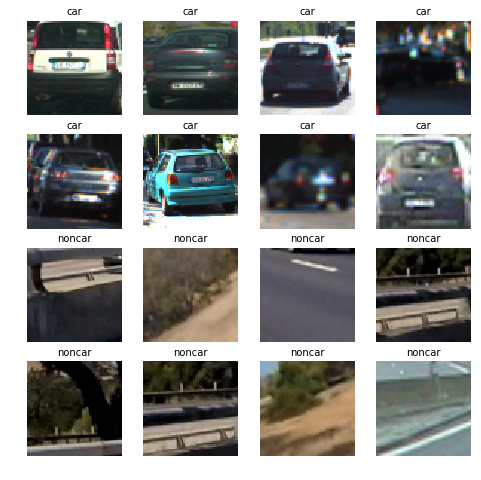

In [3]:
import matplotlib.pyplot as plt

sample_size_from_each_class = 8
fig, axis = plt.subplots(sample_size_from_each_class//2, 4, figsize=(sample_size_from_each_class,sample_size_from_each_class))
axis = axis.ravel()

for i in np.arange(sample_size_from_each_class*2):
    if i < sample_size_from_each_class:
        axis[i].imshow(car_imgs[np.random.randint(0, len(car_imgs))])
        axis[i].set_title('car', fontsize=10)
        axis[i].axis('off')
    else:
        axis[i].imshow(noncar_imgs[np.random.randint(0, len(noncar_imgs))])
        axis[i].set_title('noncar', fontsize=10)
        axis[i].axis('off')

### Autti car dataset

In [4]:
# extracting additional samples from autti dataset
import csv
import random as rand

autti_samples_cars_count = 10000
autti_samples_notcars_count = 40000
autti_images_data = {}
cars_count = 0

# get autti dataset from https://github.com/udacity/self-driving-car/tree/master/annotations
# and extract into dataset/autti-object-dataset/ folder
# reading car boxes data from csv file (lines which contains "car" in 6th row)
# as a result we will have following structute
# autti_images_data = {
#    'image_filename' : {
#        'impath' : 'path/to/image',
#        'car_boxes' : [
#                {
#                    'x1' : int, # top left coords
#                    'y1' : int,
#                    'x2' : int, # bottom right coords
#                    'y2' : int
#                },
#                ...
#                all car boxes
#            ]
#    }
#    ...
#    all files
# }

with open('dataset/object-dataset/labels.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in reader:
        fname = row [0]
        if fname not in autti_images_data:
            image_data = {
                'impath' : 'dataset/object-dataset/' + fname,
                'car_boxes' : []
            }
            autti_images_data [fname] = image_data
        else:
            image_data = autti_images_data [fname]
            
        if (row[6] == '"car"'):
            car_data = {
                'x1' : int(row [1]),
                'y1' : int(row [2]),
                'x2' : int(row [3]),
                'y2' : int(row [4])
            }
            image_data ['car_boxes'].append (car_data)
            cars_count += 1

print ('autti images:', len (autti_images_data))
print ('  cars:', cars_count)

def is_intersect (box, boxes):
    """Check if box have intersection with other boxes
    Args:
        box (dict): box coords as
            {
                'x1' : int, # top left coords
                'y1' : int,
                'x2' : int, # bottom right coords
                'y2' : int
            }
        boxes (list): list of other boxes
    Returns:
        boolean: True if box has intersection with boxes, False otherwise
    """
    x1, x2, y1, y2 = box ['x1'], box ['x2'], box ['y1'], box ['y2']
    for b in boxes:
        bx1, bx2, by1, by2 = b ['x1'], b ['x2'], b ['y1'], b ['y2']
        if (
            (
                (
                    (x1 >= bx1 and x1 <= bx2) or 
                    (x2 >= bx1 and x2 <= bx2)
                ) and
                (
                    (y1 >= by1 and y1 <= by2) or 
                    (y2 >= by1 and y2 <= by2)
                )
            ) or
            (
                (
                    (bx1 >= x1 and bx1 <= x2) or 
                    (bx2 >= x1 and bx2 <= x2)
                ) and
                (
                    (by1 >= y1 and by1 <= y2) or 
                    (by2 >= y1 and by2 <= y2)
                )
            )
        ):
            return True
        
    return False

# also not car images will be extracted from autti dataset
# not car images will be square crops with following side size
not_car_box_size = [128, 64, 48]

def gen_not_car_box (size, car_boxes):
    """Randomly generate box inside of specified boundaries
    which have no intersections with specified boxes
    Args:
        size (list or tuple): size of area to generate box within
        car_boxes (list): boxes in the area which cannot be intersected
    Return:
        box(dict): resulting box in form of {'x1' : int, 'y1' : int, 'x2' : int, 'y2' : int}
    """
    while True:
        box_size = not_car_box_size [rand.randint (0, len (not_car_box_size)-1)]
        box_size = [box_size, box_size]
        available_poss = [
            size[0] - box_size[0],
            size[1] - box_size[1],
            ]
        pos = [
            rand.randint (0, available_poss[0] - 1),
            rand.randint (0, available_poss[1] - 1)
            ]
        box = {
            'x1': pos [0],
            'y1': pos [1],
            'x2': pos [0] + box_size [0],
            'y2': pos [1] + box_size [1]
        }
        if not is_intersect (box, car_boxes):
            return box
    

def augment_from_autti_dataset (cars_count, notcars_count):
    """Randomly pick images from autti dataset, crops car and not car images.
    resulting images will be resized to (64, 64)
    Args:
        cars_count (int): number of needed car images
        notcars_count (int): number of needed not car images
    Returns:
        cars (list), notcars(list) images which were cropped from autti dataset
        lists may hold slighly less number of images since
        cars_count and notcars_count specifies number of tries to crop.
        In some rare situations we have no images to crop
    """
    images_last_index = len (autti_images_data) - 1
    augmented_cars = []
    augmented_notcars = []
    keys = list(autti_images_data.keys ())
    for i in range (max (cars_count, notcars_count)):
        if i % 200 == 0:
            print ('augmented:', i)
        
        image_data = autti_images_data [keys[rand.randint (0, images_last_index)]]
        # if there is no car we will skip this image
        if len(image_data ['car_boxes']) == 0:
            continue
        
        carbox = image_data['car_boxes'][rand.randint(0, len(image_data ['car_boxes'])-1)]

        im = mpimg.imread(image_data ['impath'])
        im = im.astype(np.float32)/255

        #get car from image
        if i < cars_count:
            car_im = im[carbox['y1']:carbox['y2'], carbox['x1']:carbox['x2']]
            car_im = cv2.resize(car_im, (64, 64), interpolation=cv2.INTER_AREA)
            augmented_cars.append (car_im)
        
        #get not car from image
        if i < notcars_count:
            notcarbox = gen_not_car_box ([im.shape[1], im.shape[0]], image_data['car_boxes'])
            notcar_im = im[notcarbox['y1']:notcarbox['y2'], notcarbox['x1']:notcarbox['x2']]
            notcar_im = cv2.resize(notcar_im, (64, 64), interpolation=cv2.INTER_AREA)
            augmented_notcars.append (notcar_im)
        
    
    return augmented_cars, augmented_notcars

# this step takes about 40 mins
augmented_cars, augmented_notcars = augment_from_autti_dataset (autti_samples_cars_count, autti_samples_notcars_count)
print ('augmented cars:', len (augmented_cars))
print ('augmented not cars:', len (augmented_notcars))

autti images: 13063
  cars: 60788
augmented: 0
augmented: 200
augmented: 400
augmented: 600
augmented: 800
augmented: 1000
augmented: 1200
augmented: 1400
augmented: 1600
augmented: 1800
augmented: 2000
augmented: 2200
augmented: 2400
augmented: 2600
augmented: 2800
augmented: 3000
augmented: 3200
augmented: 3400
augmented: 3600
augmented: 3800
augmented: 4000
augmented: 4200
augmented: 4400
augmented: 4600
augmented: 4800
augmented: 5000
augmented: 5200
augmented: 5400
augmented: 5600
augmented: 5800
augmented: 6000
augmented: 6200
augmented: 6400
augmented: 6600
augmented: 6800
augmented: 7000
augmented: 7200
augmented: 7400
augmented: 7600
augmented: 7800
augmented: 8000
augmented: 8200
augmented: 8400
augmented: 8600
augmented: 8800
augmented: 9000
augmented: 9200
augmented: 9400
augmented: 9600
augmented: 9800
augmented: 10000
augmented: 10200
augmented: 10400
augmented: 10600
augmented: 10800
augmented: 11000
augmented: 11200
augmented: 11400
augmented: 11600
augmented: 11800
aug

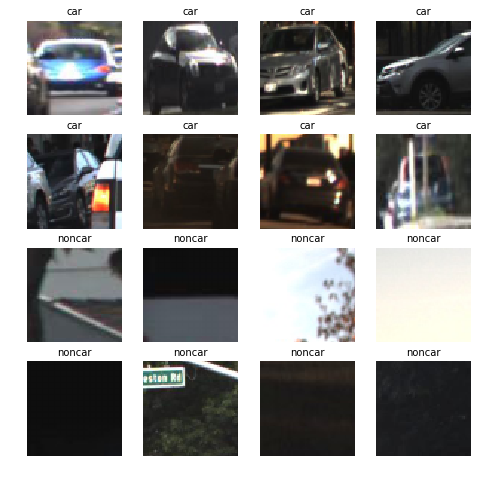

In [5]:
sample_size_from_each_class = 8
fig, axis = plt.subplots(sample_size_from_each_class//2, 4, figsize=(sample_size_from_each_class,sample_size_from_each_class))
axis = axis.ravel()

for i in np.arange(sample_size_from_each_class*2):
    if i < sample_size_from_each_class:
        axis[i].imshow(augmented_cars[np.random.randint(0, len(augmented_cars))])
        axis[i].set_title('car', fontsize=10)
        axis[i].axis('off')
    else:
        axis[i].imshow(augmented_notcars[np.random.randint(0, len(augmented_notcars))])
        axis[i].set_title('noncar', fontsize=10)
        axis[i].axis('off')

### Write augmented images for further use

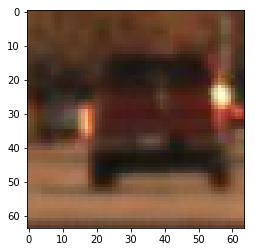

In [6]:
plt.imshow(augmented_cars[0])

In [7]:
augmented_cars[0].shape
from scipy.misc import imsave


In [8]:
for i,img in enumerate(augmented_cars):
    img_name = 'dataset/augmented-cars/'+str(i)+'.png'
    imsave(img_name,img)
    
for i,img in enumerate(augmented_notcars):
    img_name = 'dataset/augmented-non-cars/'+str(i)+'.png'
    imsave(img_name,img)

### Augmented cars reading (For faster testing)

In [9]:

augmented_car_files = glob.glob('dataset/augmented-cars/*.png')
augmented_noncar_files = glob.glob('dataset/augmented-non-cars/*.png')

print('The dataset consists of {} augmented car and {}  augmented non-car images'.format(len(augmented_car_files), len(augmented_noncar_files)))

The dataset consists of 9775 augmented car and 39144  augmented non-car images


In [10]:
import numpy as np
import cv2
%matplotlib inline
augmented_car_imgs = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in augmented_car_files]
augmented_noncar_imgs = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in augmented_noncar_files]
example_img = car_imgs[np.random.randint(0, len(car_imgs))]
print('The shape of the augmented images is: {}'.format(example_img.shape))
print("The min value is {} and the max value of the augmented image is {}".format(np.amin(example_img),
                                                                     np.amax(example_img)))

The shape of the augmented images is: (64, 64, 3)
The min value is 11 and the max value of the augmented image is 255


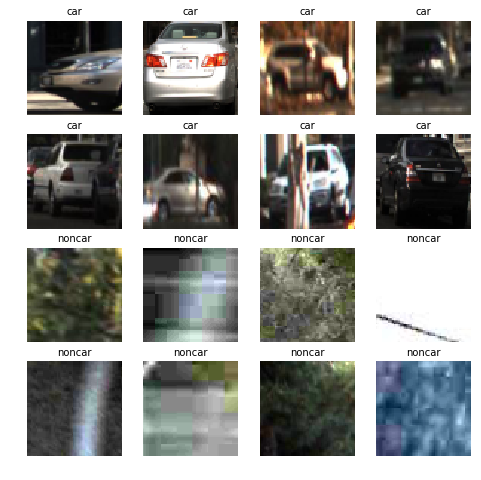

In [11]:
sample_size_from_each_class = 8
fig, axis = plt.subplots(sample_size_from_each_class//2, 4, figsize=(sample_size_from_each_class,sample_size_from_each_class))
axis = axis.ravel()

for i in np.arange(sample_size_from_each_class*2):
    if i < sample_size_from_each_class:
        axis[i].imshow(augmented_car_imgs[np.random.randint(0, len(augmented_car_imgs))])
        axis[i].set_title('car', fontsize=10)
        axis[i].axis('off')
    else:
        axis[i].imshow(augmented_noncar_imgs[np.random.randint(0, len(augmented_car_imgs))])
        axis[i].set_title('noncar', fontsize=10)
        axis[i].axis('off')

## HOG Classification

A function is defined to get the Histogram of Oriented Gradients (HOG) from the images. 

In [12]:
from skimage.feature import hog

#### Extract HOG features

In [13]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    """
    Define a function to return HOG features
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

#### Convert color scale

In [14]:
def convert_color(img, color_space='RGB'):
    """
    Function that converts the colorspace of an image
    """
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Return the color altered image
    return feature_image

#### Sample and visualize HOG output

In [15]:
def visualizeHOG(img, color_space = 'RGB', orient = 8, pix_per_cell = 8,  cell_per_block = 2):

    col_img = convert_color(img, color_space)
        

    # Call the function with vis=True to see an image output
    feat, hog_ch1 = get_hog_features(col_img[:,:,0], orient, pix_per_cell, 
                                     cell_per_block, vis=True, feature_vec=False)
    feat, hog_ch2 = get_hog_features(col_img[:,:,1], orient, pix_per_cell, 
                                     cell_per_block, vis=True, feature_vec=False)
    feat, hog_ch3 = get_hog_features(col_img[:,:,2], orient, pix_per_cell, 
                                     cell_per_block, vis=True, feature_vec=False)

    # Visualize
    fig, axs = plt.subplots(1,4, figsize=(16,16))
    axs[0].imshow(img)
    axs[1].imshow(hog_ch1, cmap='gray')
    axs[1].set_title('HOG_Ch1')
    axs[2].imshow(hog_ch2, cmap='gray')
    axs[2].set_title('HOG_Ch2')
    axs[3].imshow(hog_ch3, cmap='gray')
    axs[3].set_title('HOG_Ch3')


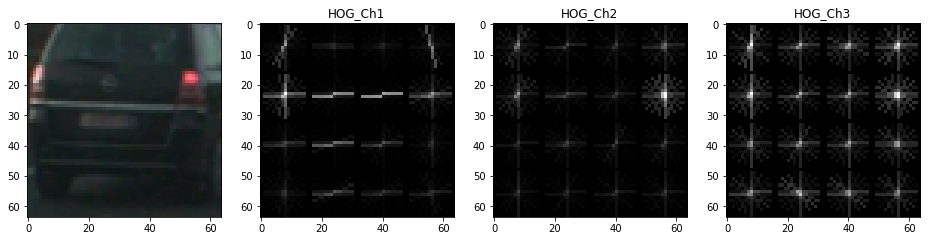

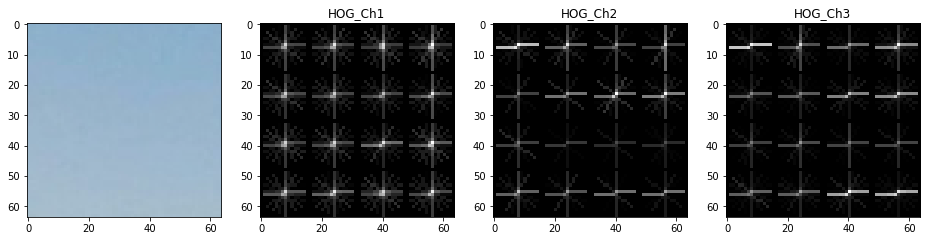

In [66]:
test_idx = 1500
car_img = car_imgs[test_idx]
noncar_img = noncar_imgs[test_idx]

# Define HOG Parameters
color_space = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

visualizeHOG(car_img, color_space, orient, pix_per_cell,  cell_per_block)
visualizeHOG(noncar_img, color_space, orient, pix_per_cell,  cell_per_block)

## Color Histogram and Spatial Binning Classify

We are going to use two more functions for the lesson that are going to help us in the classification of the images
* `bin_spatial` which computes the binned color features of the images and
* `color_hist` which computes the color histogram features of the image

In [18]:
def bin_spatial(img, size=(32, 32)):
    """
    Function that computes binned color features
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    """
    Function that computes the color histogram features
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    if vis == True:
        # Generating bin centers
        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        
        # Visualize
        fig, axs = plt.subplots(1,4, figsize=(16,3))
        axs[0].imshow(img)
        axs[1].bar(bin_centers, channel1_hist[0])
        axs[1].set_xlim(0, 256)
        axs[1].set_title('ColorHist_Ch1')
        axs[2].bar(bin_centers, channel2_hist[0])
        axs[2].set_xlim(0, 256)
        axs[2].set_title('ColorHist_Ch2')
        axs[3].bar(bin_centers, channel3_hist[0])
        axs[3].set_xlim(0, 256)
        axs[3].set_title('ColorHist_Ch3')
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Let's visualize for example the spatial binning and the color histogram of the previous car and non-car images

In [19]:
feature_car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YUV)
feature_noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YUV)

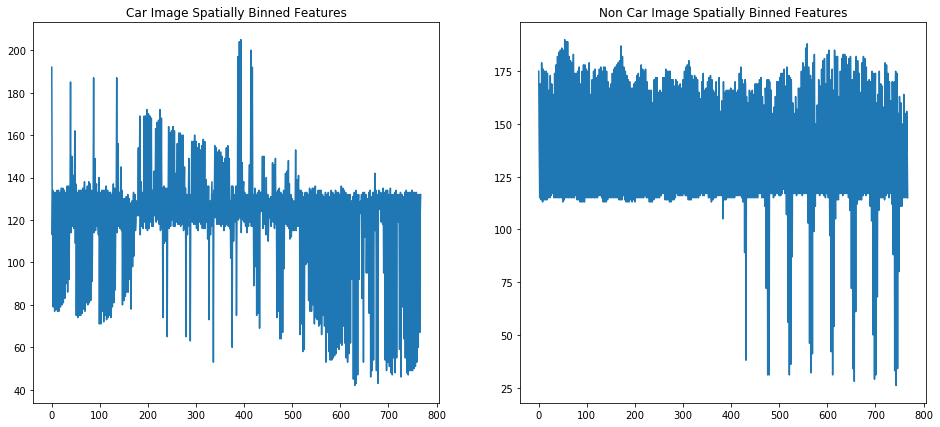

In [67]:
# Apply spatial binning
car_feature_vec = bin_spatial(feature_car_img, size=(16,16))
noncar_feature_vec = bin_spatial(feature_noncar_img, size=(16,16))

# Plot features
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
ax1.plot(car_feature_vec)
ax1.set_title('Car Image Spatially Binned Features')
ax2.plot(noncar_feature_vec)
ax2.set_title('Non Car Image Spatially Binned Features')

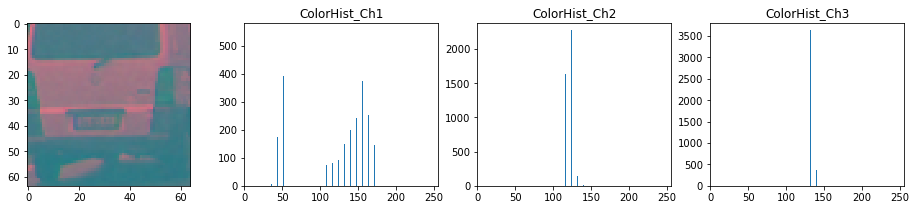

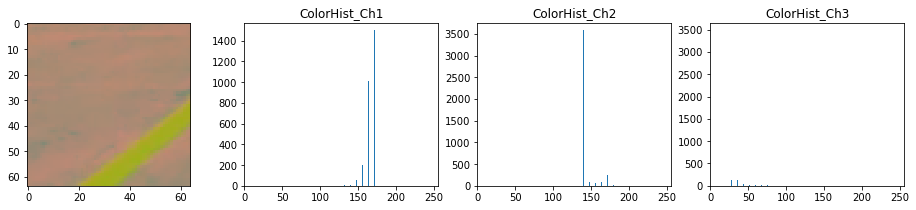

In [68]:
color_hist(feature_car_img, nbins=32, bins_range=(0, 256), vis=True)
tmp = color_hist(feature_noncar_img, nbins=32, bins_range=(0, 256), vis=True)

## Feature extraction

After we defined the methods to identify features the next step was to create a method in order to combine all of them and create a normalized feature map. The method `extract_features` does this thing.

In [21]:
def extract_features(image, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=16,
                        pix_per_cell=6, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Function to extract features from a list
    of images
    """
    # Create a list to append feature vectors to
    features = []
    file_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    if spatial_feat == True:
        # Apply bin_spatial to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    return np.concatenate((spatial_features, hist_features, hog_features))

After defining the function we are ready to tune some hyperparameters in order to extract the necessary features of the images. Some of the important parameters are:

* The colorspace (RGB, YUV, HLS, etc.)
* The HOG parameters:
    * orientation
    * pixels per cell
    * cells per block
    * channel on which the HOG is applied
* Spatial size
* Histogram bins etc.
    
As in lesson we gonna keep track of the time needed in order to finish the feature extraction. Later we are going to check also the accuracy of the classifier
which depends on the number of feature. In order to identify a good parameter set we keep track of the time of prediction later which must be close to real time
and the accuracy. If the tradeoff is satisfying we proceed to test the classifier on the `test_images`

In [64]:
# Feature extraction hyperparameters
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
sptl_size = (16,16)
nbins = 32

In [23]:
import time

## Augment with Autti dataset 

In [63]:
# combine original and autti datasets and extract features

# original dataset seems to have black cars bias
# so I use only 4000 car images and about 10K car images from autti
all_cars = []
all_cars.extend (car_imgs [:4000])
all_cars.extend (augmented_car_imgs)

# I use bigger number of not car images
all_notcars = []
all_notcars.extend (noncar_imgs)
all_notcars.extend (augmented_noncar_imgs)

In [65]:
t1 = time.time()
car_features = [extract_features(car_img, color_space=colorspace, spatial_size=sptl_size, hist_bins=nbins, 
                               orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                               hog_channel=hog_channel) for car_img in all_cars]
noncar_features = [extract_features(noncar_img, color_space=colorspace, spatial_size=sptl_size, hist_bins=nbins,
                                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                  hog_channel=hog_channel) for noncar_img in all_notcars]
t2 = time.time()

# Find the timing
print(round(t2-t1, 2), 'seconds to extract features')

426.82 seconds to extract features


In [69]:
print('Size of feature vector is', len(car_features[0]))

Size of feature vector is 2052


### Training and Test Datasets

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle



# Create the labels for car and non car features
print(len(car_features), len(noncar_features))
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))



# Create dataset
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

# Create random number
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=rand_state)

print('In training dataset we have {} features and {} labels.'.format(len(X_train), len(y_train)))
print('From them {} are car and {} are non-car images.'.format((y_train==1).sum(), (y_train==0).sum()))
print('In test dataset we have {} features and {} labels.'.format(len(X_test), len(y_test)))
print('From them {} are car and {} are non-car images.'.format((y_test==1).sum(), (y_test==0).sum()))

13775 48112
In training dataset we have 49509 features and 49509 labels.
From them 11012 are car and 38497 are non-car images.
In test dataset we have 12378 features and 12378 labels.
From them 2763 are car and 9615 are non-car images.


### Fit the classifier

In [71]:
from sklearn.svm import LinearSVC
# Use a linear SVC
svc = LinearSVC()

# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'seconds to train SVC...')

# Check accurac score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a predefined a single sample
n_predict = 10
t1=time.time()

print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()
print(round(t2-t1, 5), 'seconds to predict', n_predict, 'labels with SVC')

127.14 seconds to train SVC...
Test Accuracy of SVC =  0.9523
My SVC predicts:      [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
0.01101 seconds to predict 10 labels with SVC


## Find cars in images

In [72]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Function that draws rectangles on an image based
    on given bounding boxes array
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### HOG subsampling

In [73]:
def find_cars(img, svc, scaler, spatial_size, hist_bins, orient, pix_per_cell, 
              cell_per_block, y_start_stop, scale):

    bboxes = []
    ystart, ystop = y_start_stop
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = np.concatenate((spatial_features, hist_features, hog_features))
            test_features = scaler.transform(test_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return bboxes

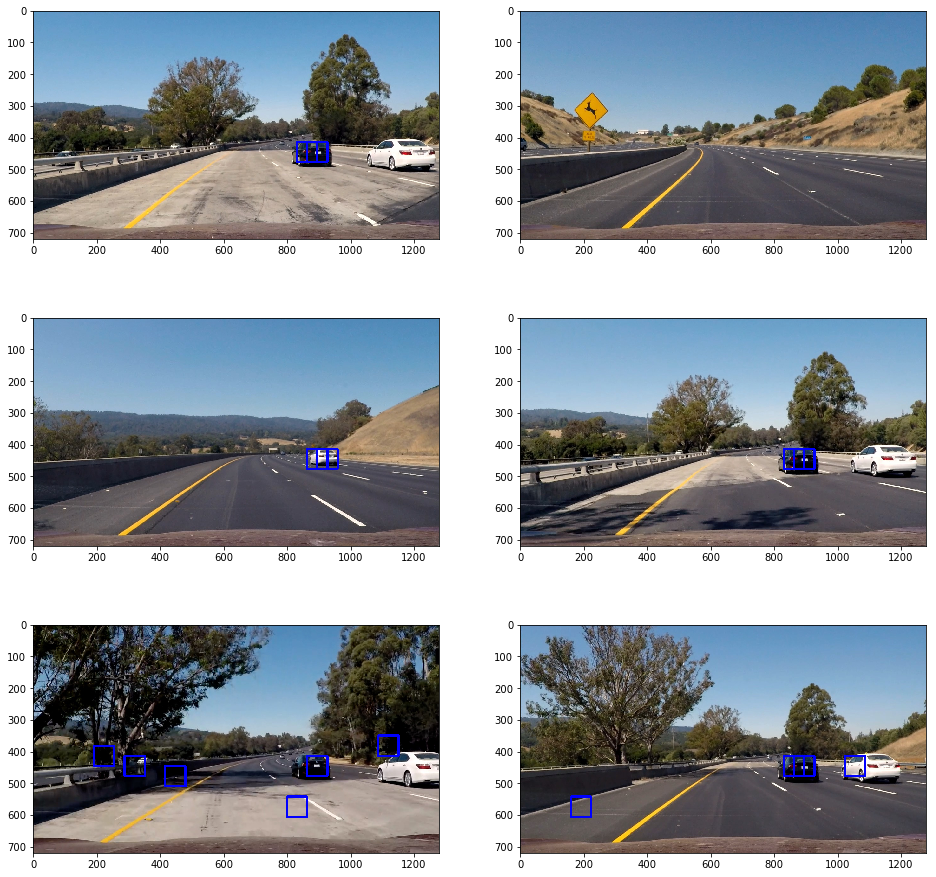

In [74]:
test_files = glob.glob('test_images/*.jpg')
test_imgs = [cv2.cvtColor(cv2.imread(test_file), cv2.COLOR_BGR2RGB) for test_file in test_files]

y_start_stop = [350, 660]
scale = 1.0

bboxes = [find_cars(img, svc, X_scaler, sptl_size, nbins, orient, pix_per_cell,
                    cell_per_block, y_start_stop, scale)
          for img in test_imgs]
# Draw the bounding boxes
out_imgs = [draw_boxes(img, bbox) for img, bbox in zip(test_imgs,bboxes)]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()

for i in np.arange(len(test_files)):
    axis[i].imshow(out_imgs[i])

In [75]:
def find_car_windows(img, svc, scaler):
    
    y_start_stop_list = [[414, 478], [446, 510], # scale 1.0
                         [398, 494], [446, 542], # scale 1.5
                         [414, 542], [478, 606], # scale 2.0
                         [385, 545], [465, 625], # scale 2.5
                         [372, 564], [468, 660]] # scale 3.0
    scales = [1.0, 1.0,
              1.5, 1.5,
              2.0, 2.0,
              2.5, 2.5,
              3.0, 3.0]
    
    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'
    sptl_size = (16,16)
    nbins = 32
    


    bboxes = [find_cars(img, svc, scaler, sptl_size, nbins, orient, pix_per_cell,
                        cell_per_block, y_start_stop, scale)
              for y_start_stop, scale in zip(y_start_stop_list, scales)]
    
    # Stack Overflow https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
    bboxes = [item for sublist in bboxes for item in sublist]
    
    return bboxes
    
    

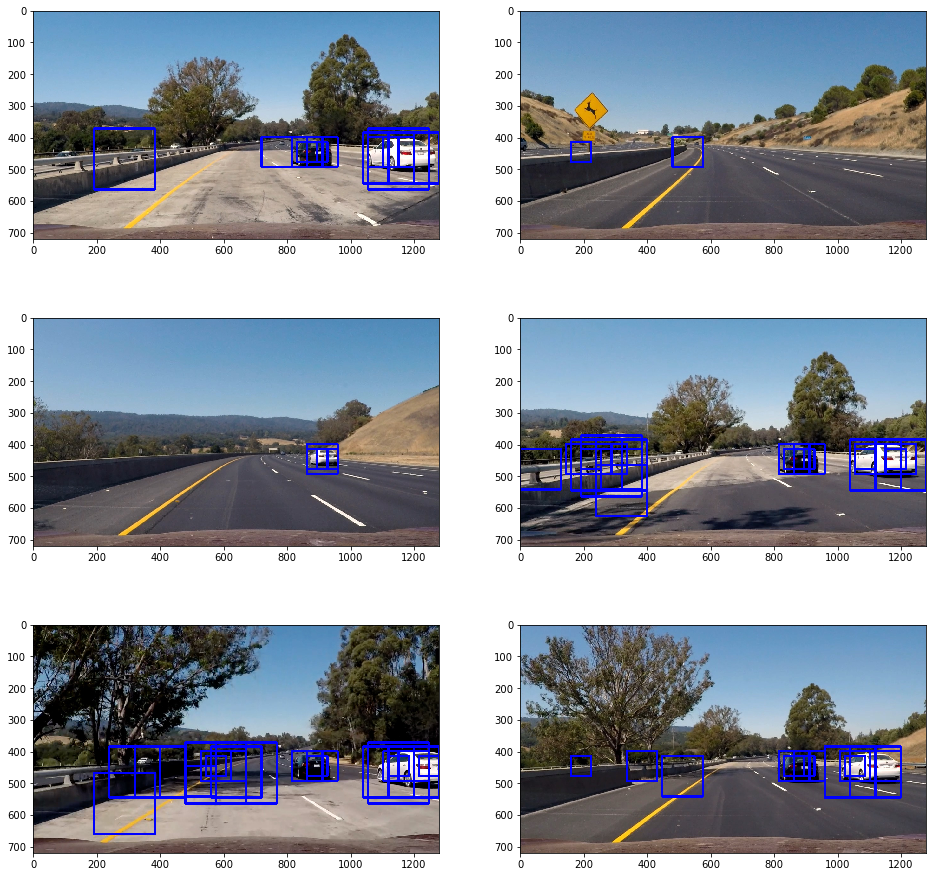

In [51]:
bboxes = [find_car_windows(test_img, svc, X_scaler) for test_img in test_imgs]

test_imgs_boxed = [draw_boxes(test_img, bbox) for test_img, bbox in zip(test_imgs, bboxes)]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()
for i in np.arange(len(test_files)):
    axis[i].imshow(test_imgs_boxed[i])

### Heatmap implementation
We notice that we have enough false positives and in order to get rid of them we are going to apply a heatmap on the images to identify the cars based on the overlap of the bounding boxes

In [76]:
def add_heat(heatmap, bbox_list):
    """
    Function that adds heat based on the bounding boxes
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

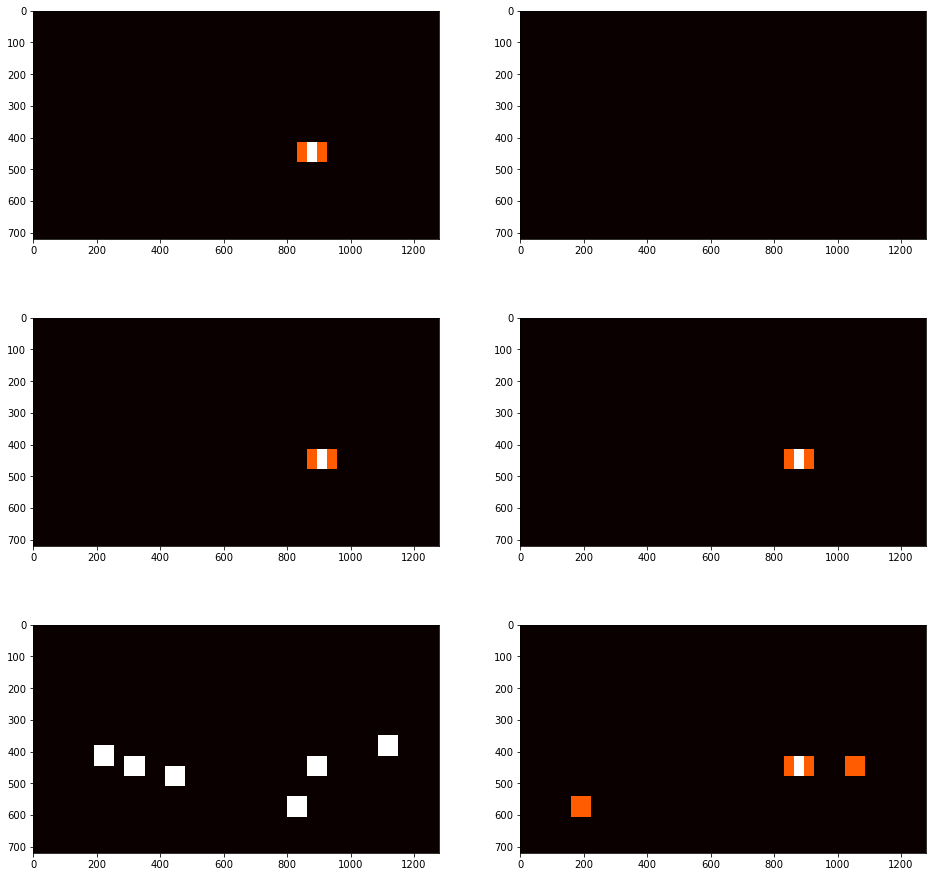

In [77]:
# Visualize heatmaps
heatmap_imgs = [np.zeros_like(img[:,:,0]).astype(np.float) for img in test_imgs]
heatmap_imgs = [add_heat(heatmap_img, bbox) for heatmap_img, bbox in zip(heatmap_imgs, bboxes)]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()
for i in np.arange(len(test_files)):
    axis[i].imshow(heatmap_imgs[i], cmap='hot')

In [78]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

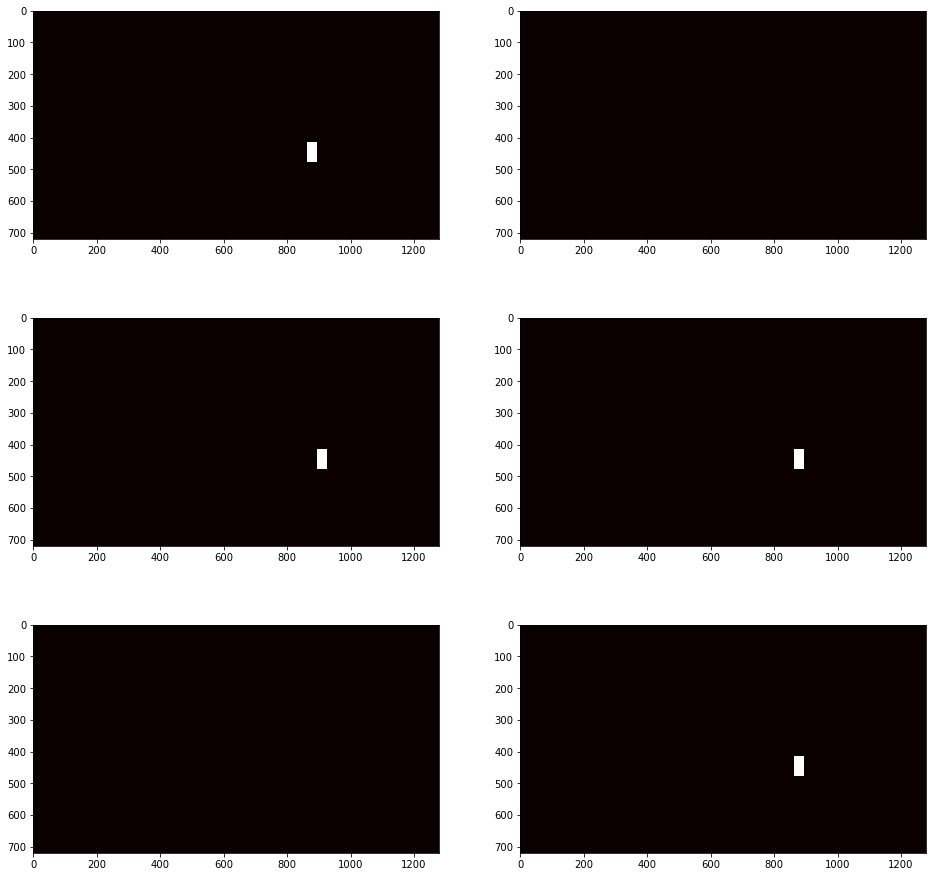

In [79]:
heatmap_imgs = [apply_threshold(heatmap_img, 1) for heatmap_img in heatmap_imgs]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()
for i in np.arange(len(test_files)):
    axis[i].imshow(heatmap_imgs[i], cmap='hot')

#### Draw labeled boxes

In [80]:
def draw_labeled_boxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [81]:
from scipy.ndimage.measurements import label

In [82]:
def processImages(img, svc, scaler, threshold=1):
    """
    Find the cars on frames
    """
    # 1) Find the bounding boxes
    bboxes = find_car_windows(img, svc, scaler)
    # 2) Create the heatmap
    heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heatmap_img, bboxes)
    # 3) Apply threshold on heamap
    heat = apply_threshold(heat,threshold)
    # 4) Find final boxes from heatmap using label function
    labels = label(heat)
    # 5) Draw the labeled boxes
    labeled_img = draw_labeled_boxes(np.copy(img), labels)
    
    return labeled_img

In [49]:
test_imgs[0].shape

(720, 1280, 3)

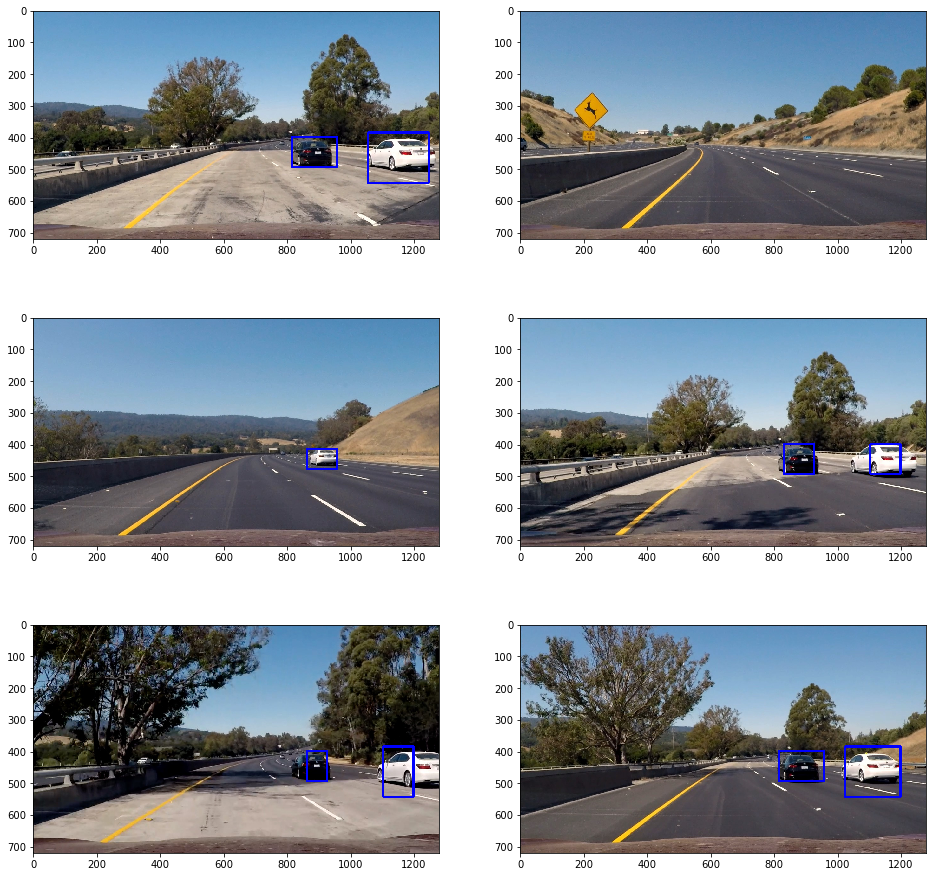

In [83]:
out_imgs = [processImages(img, svc, X_scaler, 1) for img in test_imgs]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()
for i in np.arange(len(test_files)):
    axis[i].imshow(out_imgs[i])

## Video pipeline


In [84]:
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import reduce

In [85]:
class VideoProcessor():
    def __init__(self):
        self.heatBuffer = []
        self.framecnt = 10
        self.svc = svc
        self.scaler = X_scaler
        self.threshold = 2
        
    def processFrame(self, img):
        
        # 1) Find the bounding boxes
        bboxes = find_car_windows(img, self.svc, self.scaler)
        # 2) Create the heatmap
        heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heatmap_img, bboxes)
        if len(self.heatBuffer) > self.framecnt:
            self.heatBuffer = self.heatBuffer[1:]
        self.heatBuffer.append(heat)
        heatBuffer = reduce(lambda x, y: x+y, self.heatBuffer)/self.framecnt
        
        # 3) Apply threshold on heamap
        heat = apply_threshold(heatBuffer,self.threshold)
        # 4) Find final boxes from heatmap using label function
        labels = label(heat)
        # 5) Draw the labeled boxes
        labeled_img = draw_labeled_bboxes(np.copy(img), labels)

        return labeled_img

In [86]:
outputpath = "videos_output"
if os.path.exists(outputpath) == False:
    os.mkdir(outputpath)
test_output = 'videos_output/test_video_output.mp4'
v1Processor = VideoProcessor()
clip1 = VideoFileClip('test_video.mp4')
test_clip = clip1.fl_image(v1Processor.processFrame)
%time test_clip.write_videofile(test_output, audio=False)


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

[MoviePy] >>>> Building video videos_output/test_video_output.mp4
[MoviePy] Writing video videos_output/test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:25<00:00,  1.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/test_video_output.mp4 

Wall time: 26.9 s


In [87]:
if os.path.exists(outputpath) == False:
    os.mkdir(outputpath)
project_output = 'videos_output/project_video_output.mp4'
v2Processor = VideoProcessor()
clip1 = VideoFileClip('project_video.mp4')
test_clip = clip1.fl_image(v2Processor.processFrame)
%time test_clip.write_videofile(project_output, audio=False)


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video videos_output/project_video_output.mp4
[MoviePy] Writing video videos_output/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:20<00:00,  1.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/project_video_output.mp4 

Wall time: 15min 21s
